# 👁️ Self-Attention: Jak AI rozumie kontekst? (Serce Transformera)

Przed rokiem 2017 (przed erą Transformerów) modele czytały tekst słowo po słowie, od lewej do prawej.
Problem: Przy długim zdaniu zapominały, co było na początku.

**Rozwiązanie: Attention Is All You Need.**
Mechanizm Uwagi pozwala każdemu słowu "popatrzeć" na wszystkie inne słowa w zdaniu NARAZ i zdecydować, które są dla niego ważne.

Działa to na zasadzie trzech wektorów dla każdego słowa:
1.  **Query (Q - Pytanie):** Czego szukam? (np. "Szukam kogoś, kto wyjaśni moją płeć").
2.  **Key (K - Klucz):** Co oferuję? (np. "Jestem etykietą określającą osobę").
3.  **Value (V - Wartość):** Jaka jest moja treść? (np. "Jestem wektorem słowa").

To działa jak randka w ciemno. Każde słowo sprawdza dopasowanie (Q vs K) z każdym innym słowem.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Funkcja Softmax (znasz ją z notatnika 22) - zamienia punkty na procenty
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# 1. DANE WEJŚCIOWE (Embeddings)
# Wyobraźmy sobie zdanie z 3 słów: "Bank dał kredyt".
# Każde słowo to wektor 4-wymiarowy (uproszczenie).

words = ["Bank", "Dał", "Kredyt"]

# Symulujemy wektory (Embeddings)
# W prawdziwym życiu te liczby są wyuczone przez model.
inputs = np.array([
    [1, 0, 0, 1],  # Bank (ma cechy finansowe)
    [0, 1, 1, 0],  # Dał (czasownik, akcja)
    [0, 1, 0, 1]   # Kredyt (finanse + akcja)
])

print("--- WEJŚCIE (Słowa jako liczby) ---")
print(inputs)

--- WEJŚCIE (Słowa jako liczby) ---
[[1 0 0 1]
 [0 1 1 0]
 [0 1 0 1]]


## Krok 1: Obliczanie Punktów Uwagi (Attention Scores)

Teraz każde słowo "zapyta" każde inne słowo: *"Jak bardzo do siebie pasujemy?"*.
Robimy to za pomocą **Iloczynu Skalarnego (Dot Product)**. To bardzo podobne do *Cosine Similarity*, które robiliśmy w RAG.

Obliczymy macierz $Q \times K^T$.
*   Jeśli wynik jest wysoki -> Słowa są silnie powiązane.
*   Jeśli niski -> Ignoruj to słowo.

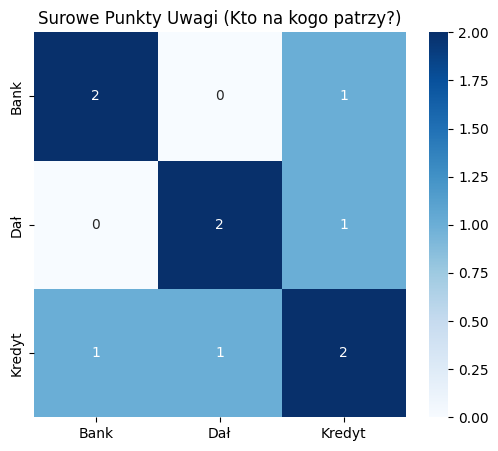

Analiza:
Patrz na skrzyżowanie 'Bank' i 'Kredyt' (1). Jest powiązanie!
Ale 'Bank' i 'Dał' (0) mają słabe powiązanie w naszym modelu.


In [2]:
# W uproszczeniu przyjmijmy, że Q = K = V = inputs (dla Self-Attention bez wag)
# W prawdziwym GPT są tu jeszcze macierze wag (Wq, Wk, Wv), ale matematyka jest ta sama.

# Mnożymy macierze: Słowa x Słowa
# To nam powie, jak bardzo "Bank" pasuje do "Kredyt".
raw_scores = np.dot(inputs, inputs.T)

# Rysujemy mapę ciepła
plt.figure(figsize=(6, 5))
sns.heatmap(raw_scores, annot=True, xticklabels=words, yticklabels=words, cmap="Blues")
plt.title("Surowe Punkty Uwagi (Kto na kogo patrzy?)")
plt.show()

print("Analiza:")
print("Patrz na skrzyżowanie 'Bank' i 'Kredyt' (1). Jest powiązanie!")
print("Ale 'Bank' i 'Dał' (0) mają słabe powiązanie w naszym modelu.")

## Krok 2: Normalizacja (Softmax)

Surowe punkty mogą być dowolne (np. 100, 500, -20).
Musimy je zamienić na **prawdopodobieństwo (Wagi)**, które sumuje się do 1 (100%).
Dzięki temu model wie: *"Skup 80% uwagi na słowie 'Kredyt', a 20% na słowie 'Dał'"*.

Przy okazji dzielimy wyniki przez pierwiastek z wymiaru ($\sqrt{d_k}$), żeby ustabilizować liczby (tzw. Scaled Dot-Product Attention).

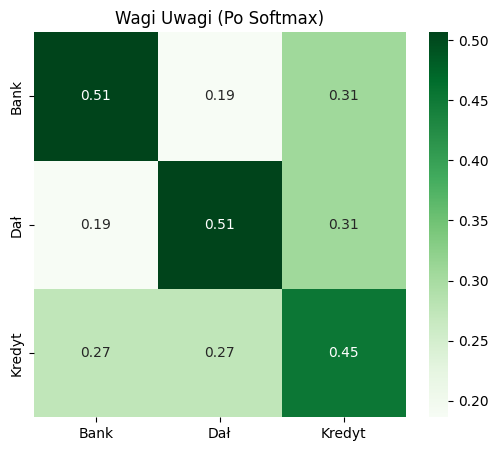

To jest serce Transformera.
Każdy wiersz sumuje się do 1.0.
Widzimy, ile 'uwagi' słowo poświęca innym.


In [3]:
d_k = inputs.shape[1] # Wymiar wektora (u nas 4)

# Skalowanie
scaled_scores = raw_scores / np.sqrt(d_k)

# Softmax (wierszami - dla każdego słowa osobno)
# apply_along_axis pozwala zrobić softmax dla każdego wiersza
attention_weights = np.apply_along_axis(softmax, 1, scaled_scores)

plt.figure(figsize=(6, 5))
sns.heatmap(attention_weights, annot=True, fmt=".2f", xticklabels=words, yticklabels=words, cmap="Greens")
plt.title("Wagi Uwagi (Po Softmax)")
plt.show()

print("To jest serce Transformera.")
print("Każdy wiersz sumuje się do 1.0.")
print("Widzimy, ile 'uwagi' słowo poświęca innym.")

## Krok 3: Kontekstualizacja (Nowe Wektory)

Ostatni krok. Mamy wagi. Teraz tworzymy **nowe wektory słów**.
Stary wektor słowa "Bank" był statyczny.
Nowy wektor słowa "Bank" będzie mieszanką:
$$ NowyBank = (Waga_{Bank} \times Bank) + (Waga_{Dał} \times Dał) + (Waga_{Kredyt} \times Kredyt) $$

Dzięki temu słowo "Bank" "wchłania" trochę znaczenia ze słowa "Kredyt". Staje się "Bankiem finansowym", a nie "Bankiem rzecznym".

In [4]:
# Mnożenie wag przez wartości (V)
output = np.dot(attention_weights, inputs)

print("--- ORYGINALNE WEKTORY ---")
print(inputs)
print("\n--- NOWE WEKTORY (Z KONTEKSTEM) ---")
print(output)

print("-" * 30)
print("Co się zmieniło?")
print("Spójrz na pierwszy wiersz (Bank).")
print("Oryginał: [1, 0, 0, 1]")
print(f"Nowy:     {output[0]}")
print("Nowy wektor nie jest już pusty w środku! Został 'zabarwiony' przez sąsiadów.")

--- ORYGINALNE WEKTORY ---
[[1 0 0 1]
 [0 1 1 0]
 [0 1 0 1]]

--- NOWE WEKTORY (Z KONTEKSTEM) ---
[[0.50648039 0.49351961 0.18632372 0.81367628]
 [0.18632372 0.81367628 0.50648039 0.49351961]
 [0.27406862 0.72593138 0.27406862 0.72593138]]
------------------------------
Co się zmieniło?
Spójrz na pierwszy wiersz (Bank).
Oryginał: [1, 0, 0, 1]
Nowy:     [0.50648039 0.49351961 0.18632372 0.81367628]
Nowy wektor nie jest już pusty w środku! Został 'zabarwiony' przez sąsiadów.


## 🧠 Podsumowanie: Dlaczego to jest rewolucja?

To, co właśnie policzyliśmy, to **pojedyncza głowica uwagi (Single Attention Head)**.

GPT-4 ma takich głowic tysiące.
*   Jedna głowica uczy się gramatyki (kto co zrobił?).
*   Druga głowica uczy się rymów.
*   Trzecia uczy się kodu HTML.

**Tu jest haczyk.**
Największą zaletą tego mechanizmu jest **Równoległość**.
W starych sieciach (RNN) musiałeś przeczytać słowo nr 1, żeby zrozumieć nr 2.
W Transformerach (dzięki macierzom, które tu widziałeś) możemy policzyć uwagę dla WSZYSTKICH słów w książce **jednocześnie**.
Dlatego możemy trenować GPT na całym internecie w rozsądnym czasie, używając tysięcy kart graficznych GPU.